## Timeseries analysis of the evolution of sponsoring domains in videos

In [1]:
import findspark
findspark.init()

from datetime import datetime

import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

import numpy as np
import seaborn as sns
import pandas as pd

from pyspark.sql.functions import explode, udf, count, collect_list
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, LongType, StringType, DateType, ArrayType, BooleanType, FloatType

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm

from pyspark.sql import SparkSession
import pyspark
import pyspark.pandas as ps
config = pyspark.SparkConf()
config.set('spark.executor.heartbeatInterval', '3600s')
config.set('spark.network.timeout', '7200s')
config.set('spark.driver.memory', '16g')
sc = pyspark.SparkContext('local[*]', '', conf=config) # write 'local' for single-threaded execution and 'local[*]' for multi-threaded execution
spark = SparkSession(sc)

ps.set_option("plotting.backend", "matplotlib")

plt.style.use('ggplot')

In [2]:
def str2list(x):
    """Function used to cast a string list into the ArrayType(StringType()) type of PySaprk.

    Args:
        x: the column to be casted

    Returns:
        the casted column
    """
    if x == '[]':
        return list()
    else:
        return x.replace('[', '').replace(']', '').split(',')
    
str2list_udf = udf(str2list, ArrayType(StringType()))

In [3]:
PATH_METADATAS_DOMAINS_SRC = '../data/generated/yt_metadata_sponsor_en_domains.parquet'
PATH_DOMAINS = '../data/generated/yt_metadata_en_domains.parquet'
PATH_SPONSORS = '../data/domains_classification.csv'

schema_metadatas_domains = StructType([
    StructField("display_id",    StringType(),            True),
    StructField("domains",       ArrayType(StringType()), True),
    StructField("domains_count", IntegerType(),           True),
    StructField("is_sponsored",  BooleanType(),           True)
])
schema_domain_metadatas = StructType([
    StructField("categories",    StringType(),            True),
    StructField("channel_id",    StringType(),            True),
    StructField("dislike_count", DoubleType(),            True), # This field must be specified as a double as it is represented as a floating point number
    StructField("display_id",    StringType(),            True),
    StructField("duration",      IntegerType(),           True),
    StructField("like_count",    DoubleType(),            True), # This field must be specified as a double as it is represented as a floating point number
    StructField("tags",          StringType(),            True),
    StructField("title",         StringType(),            True),
    StructField("upload_date",   DateType(),              True),
    StructField("view_count",    DoubleType(),            True),  # This field must be specified as a double as it is represented as a floating point number
    StructField("domains",       ArrayType(StringType()), True), 
    StructField("domains_count", IntegerType(),           True),
    StructField("has_domains",   BooleanType(),           True),
])

# Read the required files
domain_metadatas = spark.read.parquet(PATH_METADATAS_DOMAINS_SRC, schema=schema_metadatas_domains)
domains = spark.read.parquet(PATH_DOMAINS, schema=schema_domain_metadatas)
sponsors = spark.read.csv(PATH_SPONSORS, header=True, inferSchema=True)

# And cast the columns to the appropriate types
domain = domains \
    .withColumn("dislike_count", domains.dislike_count.cast(IntegerType())) \
    .withColumn("like_count", domains.like_count.cast(IntegerType())) \
    .withColumn("view_count", domains.view_count.cast(LongType())) \

domain_metadatas = domain_metadatas \
      .withColumn("domain_categories", str2list_udf(domain_metadatas.domain_categories))

sponsors = sponsors \
    .withColumn("is_sponsored", sponsors.is_sponsored.cast(BooleanType()))

(domain_metadatas.dtypes, domains.dtypes, sponsors.dtypes)

([('display_id', 'string'),
  ('domains', 'array<string>'),
  ('domain_categories', 'array<string>'),
  ('is_sponsored', 'boolean')],
 [('categories', 'string'),
  ('channel_id', 'string'),
  ('dislike_count', 'int'),
  ('display_id', 'string'),
  ('duration', 'int'),
  ('like_count', 'int'),
  ('tags', 'string'),
  ('title', 'string'),
  ('upload_date', 'date'),
  ('view_count', 'bigint'),
  ('domains', 'array<string>'),
  ('domains_count', 'int'),
  ('has_domains', 'string')],
 [('domain', 'string'),
  ('count', 'int'),
  ('median_sponsor_score', 'double'),
  ('is_sponsored', 'boolean'),
  ('domain_category', 'string')])

### Evolution of rstyle.me and play.google.com over time

In [4]:
# We join domain_metadatas and domains with display_id
# but only take columns in domains that are not in domain_metadatas
videos = domain_metadatas \
    .join(
        domains.select(
            'display_id',
            'channel_id',
            'title',
            'upload_date',
            'duration',
            'view_count',
            'like_count',
            'dislike_count',
            'tags'),
        on='display_id', how='inner'
    )

In [5]:
# We explode the domains column to get a row of video per domain and join with sponsors
# to get the category of each domain
# We then replace the None values of is_sponsored with False
# Finally, we drop duplicated lines
videos = videos \
    .drop('domain_categories', "is_sponsored") \
    .withColumn('domain', explode('domains')) \
    .drop('domains') \
    .join(sponsors.select("domain", "is_sponsored", "domain_category"), on='domain', how='left') \
    .na.fill(False, subset=['is_sponsored']) \
    .dropDuplicates()

In [6]:
# Create a column months that contains the year and the month of the upload_date and cast it to a date
videos = videos \
    .withColumn('month', videos.upload_date.substr(1, 7).cast(DateType()))

In [7]:
videos.dtypes

[('domain', 'string'),
 ('display_id', 'string'),
 ('channel_id', 'string'),
 ('title', 'string'),
 ('upload_date', 'date'),
 ('duration', 'int'),
 ('view_count', 'bigint'),
 ('like_count', 'int'),
 ('dislike_count', 'int'),
 ('tags', 'string'),
 ('is_sponsored', 'boolean'),
 ('domain_category', 'string'),
 ('month', 'date')]

In [ ]:
# get the size of the dataset
# videos.count()

70703963

In [8]:
# We only get the videos that are sponsored and contain rsteyle.me or play.google.com in their domain
videos_cnt = (videos
        .filter((videos.is_sponsored) & ((videos.domain == "rstyle.me") | (videos.domain == "play.google.com"))).persist()
        .pandas_api()
        .groupby(['month', "domain"])
        .size()
        .reset_index()
        .sort_index()
        .rename(columns={0: "count"})
        .astype({"month": "datetime64[ns]"})
)
videos_cnt.dtypes

month     datetime64[ns]
domain            object
count              int64
dtype: object

In [11]:
videos_cnt.head(10)

,month,domain,count
0,2018-11-01,play.google.com,53160
1,2016-11-01,play.google.com,18004
2,2018-07-01,rstyle.me,2741
3,2014-11-01,play.google.com,5227
4,2018-01-01,rstyle.me,2641
5,2010-06-01,play.google.com,837
6,2016-08-01,play.google.com,15855
7,2014-01-01,play.google.com,2529
8,2018-08-01,rstyle.me,2770
9,2016-11-01,rstyle.me,1539


In [12]:
# Transpose the domain column to get a column for each domain to plot them later
videos_cnt_t = videos_cnt.pivot(index='month', columns='domain', values='count').sort_index().fillna(0)
videos_cnt_t.head(10)

domain,play.google.com,rstyle.me
month,,
2006-03-01,6,0
2006-06-01,2,0
2006-07-01,3,0
2006-08-01,4,0
2006-09-01,8,0
2006-10-01,5,0
2006-11-01,4,0
2006-12-01,3,0
2007-01-01,9,0


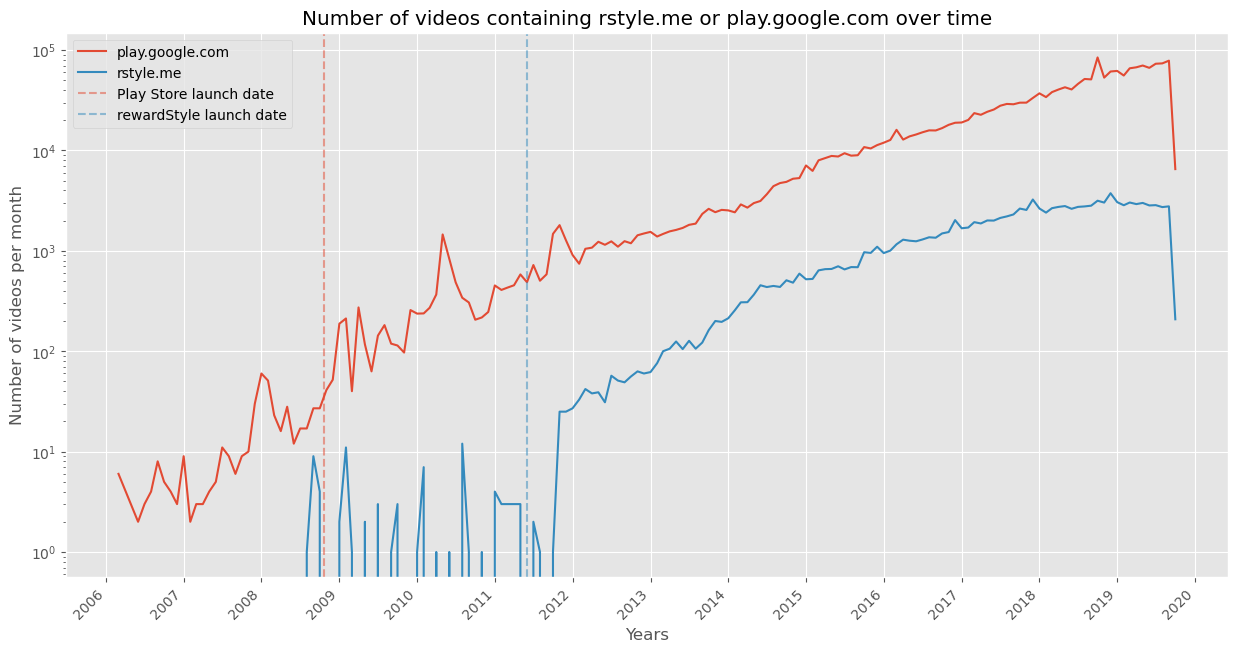

In [13]:
# Plot the number of videos that contain this domain over each month
videos_cnt_t.plot.line(figsize=(15, 8))
plt.title("Number of videos containing rstyle.me or play.google.com over time")
plt.xlabel("Years")
plt.ylabel("Number of videos per month")
plt.yscale("log")
# Plot a red line at 2008-10-22 as it is the start of the Play Store
plt.axvline(x='2008-10-22', color='C0', linestyle='--', label='Play Store launch date', alpha=0.5)
# Plot a blue line at 2011-06-01 as it is the start of renweStyle
plt.axvline(x='2011-06-01', color='C1', linestyle='--', label='rewardStyle launch date', alpha=0.5)
# Show each year on the x-axis as dates
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
plt.legend()
plt.savefig("rstyle_play_google.svg", format="svg")
plt.show()

In [115]:
cnt_go_rs = (videos
        .filter((videos.is_sponsored) & ((videos.domain == "rstyle.me") | (videos.domain == "play.google.com")))
        .pandas_api()
        .groupby(['upload_date', "domain"])
        .size()
        .reset_index()
        .sort_index()
        .rename(columns={0: "count"})
)

In [116]:
cnt_sub_pivot = cnt_go_rs.pivot(index='upload_date', columns='domain', values='count').sort_index().fillna(0)

C:\spark\spark-3.3.1-bin-hadoop3\python\pyspark\pandas\utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


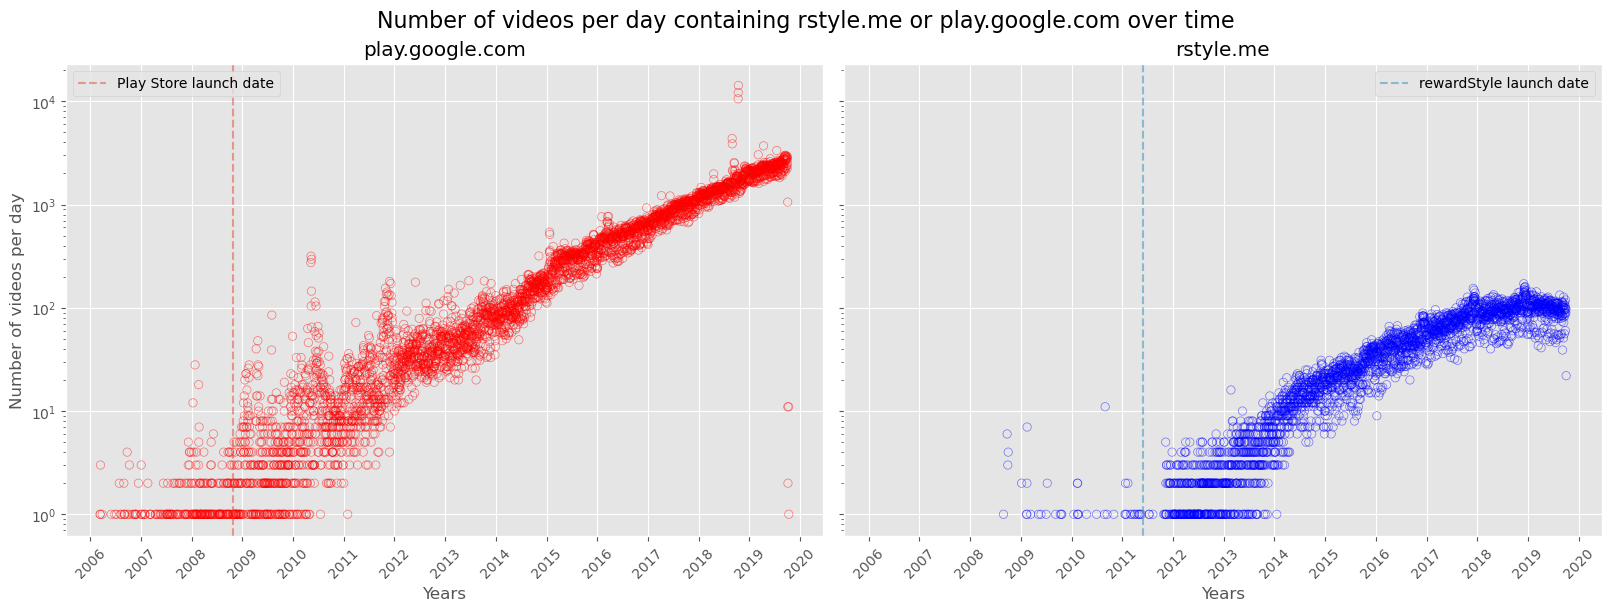

In [125]:
to_plot = cnt_sub_pivot.reset_index().to_pandas()

fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True, layout="constrained")

ax[0].scatter(x=to_plot["upload_date"], y=to_plot["play.google.com"], alpha=0.5, facecolors='none', edgecolors='r')
ax[1].scatter(x=to_plot["upload_date"], y=to_plot["rstyle.me"], alpha=0.5, facecolors='none', edgecolors='b')
plt.yscale("log")
# Plot a red line at 2008-10-22 as it is the start of the Play Store
ax[0].axvline(x=datetime.strptime("2008-10-22", "%Y-%m-%d"), color='C0', linestyle='--', label='Play Store launch date', alpha=0.5)
# Plot a blue line at 2011-06-01 as it is the start of renweStyle
ax[1].axvline(x=datetime.strptime("2011-06-01", "%Y-%m-%d"), color='C1', linestyle='--', label='rewardStyle launch date', alpha=0.5)
# Show each year on the x-axis as dates
ax[0].xaxis.set_major_locator(mdates.YearLocator())
ax[1].xaxis.set_major_locator(mdates.YearLocator())
ax[0].set_title("play.google.com")
ax[1].set_title("rstyle.me")
ax[0].set_xlabel("Years")
ax[1].set_xlabel("Years")
ax[0].set_ylabel("Number of videos per day")
ax[0].legend(loc="upper left")
ax[1].legend()

#rotate the x-axis labels 
for ax in fig.axes:
    plt.sca(ax)
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=45)
fig.suptitle("Number of videos per day containing rstyle.me or play.google.com over time", size=16)
plt.savefig("../images/rstyle_play_google_days.svg", format="svg") 
plt.show()

We can see that videos mentioning rewardStyle (rstyle.me) appeared around $2008$ whereas the ones mentioning the Google Play Store (play.google.com) appeared around $2006$. We can also see that rewardStyle starts in a rather rough manner. Indeed, there are multiple months where no videos mention the domain after its first appearance before it starts to get mentioned on a regular basis after the end of $2011$. The same cannot be said for the Google Play. It is mentioned on videos from the very beginning and on a regular basis. \
We can also see that the number of videos posted every months for both increase exponentially after $2012$. \
It is interessting to note that the Google Play Store was officially launched on the [$22\text{nd of Octobre }2008$](https://en.wikipedia.org/wiki/Google_Play), so it is rather surprising to see videos mentioning it before that date. We will explore this a bit further in the following cells bellow. \
We can say the same abount rewardStyle. According to [crunchbase.com](https://www.crunchbase.com/organization/rewardstyle), the company was founded on the $\text{1st of June }2011$. 
We will explore this a bit further in the following cells bellow.

In [126]:
# Get videos that are sponsored by play.google.com that are before 2008-10-22
play_videos = videos \
    .filter((videos.is_sponsored) & (videos.domain == "play.google.com") & (videos.upload_date < "2008-10-22")) \
    .pandas_api() \
    .astype({"month": "datetime64[ns]"})
print(f"The number of videos mentioning play.google.com before 2008-10-22 is {play_videos.shape[0]}.")
play_videos.head(10)

The number of videos mentioning play.google.com before 2008-10-22 is 407.


,domain,display_id,channel_id,title,upload_date,duration,view_count,like_count,dislike_count,tags,is_sponsored,domain_category,month
0,play.google.com,2bFS3hjS8oo,UCKkq4T-M1hYpptJRZwdxTJA,Zuby Raps About Oxford University Student Life,2006-11-21,77,11215,42,5,"zuby,oxford,oxford rap,oxford rapper,oxford un...",True,Application,2006-11-01
1,play.google.com,8bGYF5h2IJs,UCVNoZyj0kA8YL1X9flCVlxQ,"Alexander O'Neal ft. Russell Watson - ""To All ...",2008-06-06,233,4889,11,0,"Russell Watson,To All The Girls I've Loved Bef...",True,Application,2008-06-01
2,play.google.com,DYgoWQbPrHA,UC-SGiJ6GQ0i6cvEqbl293xg,Ryan Farish - Road To You (Official Video),2007-12-12,237,55857,255,8,"Ryan Farish,Road to You,Official Video,Video,R...",True,Application,2007-12-01
3,play.google.com,IZRhrPcTVJo,UCVKca2tBe83V9GR5f-YnW6g,Brazilian Jiu Jitsu | Training Log May 2007 | ...,2007-05-28,157,3981,6,1,"BJJ,grappling,roy,dean,jujutsu,brazilian,jiu,j...",True,Application,2007-05-01
4,play.google.com,J-LqLU7CxeA,UCoMdktPbSTixAyNGwb-UYkQ,Builder Demolishes His Work After Pay Dispute ...,2008-04-23,115,5779450,23555,1799,"sky,news,builder,pay,dispute,demolish,home,ham...",True,Application,2008-04-01
5,play.google.com,WsXLQZpqWTA,UCmdQ5iTjEF2tZTfU-pTa2aQ,Mini ortoGig,2006-09-05,875,28736,241,20,"ortopilot,live,video,gig,acoustic,band,album,p...",True,Application,2006-09-01
6,play.google.com,hKFfYr7at9s,UC5VYrVnw-v9UPN75q6ckGIg,K-Ci and Jojo - All My Life - Acoustic w/ Chlo...,2008-01-04,140,946681,3372,357,"davidchoimusic,david,choi,K-Ci,and,Jojo,All,My...",True,Application,2008-01-01
7,play.google.com,mg6XxcT4l7c,UCQ3LBcZNzPIAJv1ktEB8Y6g,Fuel Tank Level Sensor,2008-01-26,161,234575,202,34,"Fuel level,auto diagnostic,scanner,sensor,OBD ...",True,Application,2008-01-01
8,play.google.com,nb6mEPc4X18,UCVNoZyj0kA8YL1X9flCVlxQ,Alexander O'Neal & Mica Paris on GMTV's Lorrai...,2008-01-17,302,2622,6,0,"Mica Paris,Alexander O'Neal,Alexander ONeal,Al...",True,Application,2008-01-01
9,play.google.com,qC6QQ3T6ULA,UCQ3LBcZNzPIAJv1ktEB8Y6g,Scanning LOAD Parameter,2008-01-26,79,4021,9,0,"parameter,load,OBD II PID,Scanner,Automotive,s...",True,Application,2008-01-01


In [127]:
# Get videos that are sponsored by rstyle.me that are before 2011-06-01
style_videos = videos \
    .filter((videos.is_sponsored) & (videos.domain == "rstyle.me") & (videos.upload_date < "2011-06-01")) \
    .pandas_api() \
    .astype({"month": "datetime64[ns]"})
print(f"The number of videos mentioning play.google.com before 2011-06-01 is {style_videos.shape[0]}.")
style_videos.head(10)

The number of videos mentioning play.google.com before 2011-06-01 is 77.


,domain,display_id,channel_id,title,upload_date,duration,view_count,like_count,dislike_count,tags,is_sponsored,domain_category,month
0,rstyle.me,LbYJD0wioaE,UCNnnebGhmIJ8MQ4X1HwphRw,Disney Dream: Minnie Mouse,2011-01-25,93,3486,6,0,"Disney,Dream,Minnie,Mouse",True,Agency,2011-01-01
1,rstyle.me,P869tcmaNXU,UCNnnebGhmIJ8MQ4X1HwphRw,Best Beauty Salon 2010 Hoodie Award Winner,2010-08-31,152,22042,33,2,"Wendy Raquel Robinson,best beauty salon,tampa,...",True,Agency,2010-08-01
2,rstyle.me,yxKXZVt4wxM,UCNnnebGhmIJ8MQ4X1HwphRw,Steve Harvey Rips Bill O'Reilly Part 2,2009-07-10,354,29135,241,6,"steve harvey,michael jackson,bill oreilly,raci...",True,Agency,2009-07-01
3,rstyle.me,bHVOxhEpjp0,UCuYx81nzzz4OFQrhbKDzTng,Lady Gaga Bad Romance Look,2010-01-18,453,56126937,210473,16399,"Lady Gaga,Bad Romance,Makeup,Look,Michelle Pha...",True,Agency,2010-01-01
4,rstyle.me,bCYvDoWM-G8,UCNnnebGhmIJ8MQ4X1HwphRw,Patti Labelle Opens up the 2008 6th Annual Hoo...,2009-01-06,420,84284,409,12,"steve harvey,patti labelle,cedric the entertai...",True,Agency,2009-01-01
5,rstyle.me,Aowdy1Ar_f4,UCKHO2e2sy2wqu1Ch8j7zfrA,February 5 favorites and 1 Regret,2011-03-01,490,20407,364,14,"February,favorites,and,Regret,beauty,review,li...",True,Agency,2011-03-01
6,rstyle.me,sHLWj27-f7M,UCNnnebGhmIJ8MQ4X1HwphRw,Disney Dream - Harvey Family Vacation,2011-01-25,121,216076,1015,37,"Disney Dream,Steve Harvey,Vacation,Fun,Beach,c...",True,Agency,2011-01-01
7,rstyle.me,jatbSHju2MQ,UCNnnebGhmIJ8MQ4X1HwphRw,Family Feud: Name something that gets passed a...,2011-02-11,129,103347,585,12,"steve harvey,passed around,joint,funny,family ...",True,Agency,2011-02-01
8,rstyle.me,4-rrKxULseg,UCNnnebGhmIJ8MQ4X1HwphRw,Disney's Dreamers Academy Stories of Success,2009-02-15,91,2596,3,0,"youth,motivation,enrichment",True,Agency,2009-02-01
9,rstyle.me,5LYAEz777AU,UCRSfmNCRk58D-aL5vZdBLow,25 Ways to Wear a Scarf in 4.5 Minutes!,2011-04-01,295,44006084,331641,8495,"how to tie a scarf,tie a scarf,ways to wear a ...",True,Agency,2011-04-01


There are $407$ videos that mention play.google.com before the Play Store even exists and $77$ before rewardStyle was created. When it now comes to it, this might be due to the fact that YouTube allows users to modify the description of their videos, and hence people might have modified them to include the Play Store or rewardStyle links aftwerwards. For example, the video with `display_id` J-LqLU7CxeA ([https://www.youtube.com/watch?v=J-LqLU7CxeA](https://www.youtube.com/watch?v=J-LqLU7CxeA)) is a video of Sky News from the $23\text{rd of April }2008$. The description of the video mentions the Play Store link of the Sky News app on Android. One can image that after the launch of their App, Sky News modified all their videos to include that link.

### Evolution of different types of sponsoring domains over time (Style and Technology)

In [128]:
videos_agencies = (videos
        .filter(
                (videos.is_sponsored) & (
                        (videos.domain == "rstyle.me") | 
                        (videos.domain == "octoly.com") |
                        (videos.domain == "unionforgamers.com") |
                        (videos.domain == "freedom.tm")
                )
        ).persist()
        .pandas_api()
        .groupby(['month', "domain"])
        .size()
        .reset_index()
        .sort_index()
        .rename(columns={0: "count"})
        .astype({"month": "datetime64[ns]"})
)
videos_agencies.dtypes

month     datetime64[ns]
domain            object
count              int64
dtype: object

In [129]:
# Pivot the dataframe to get a row per month and a column per domain
videos_agencies = videos_agencies.pivot(index='month', columns='domain', values='count').sort_index().fillna(0)
videos_agencies.head(10)

domain,freedom.tm,octoly.com,rstyle.me,unionforgamers.com
month,,,,
2008-08-01,0,0,1,0
2008-09-01,0,0,9,0
2008-10-01,0,0,4,0
2008-11-01,0,2,0,0
2009-01-01,0,0,2,0
2009-02-01,0,0,11,0
2009-03-01,0,0,1,0
2009-05-01,0,0,2,0
2009-06-01,0,2,0,0


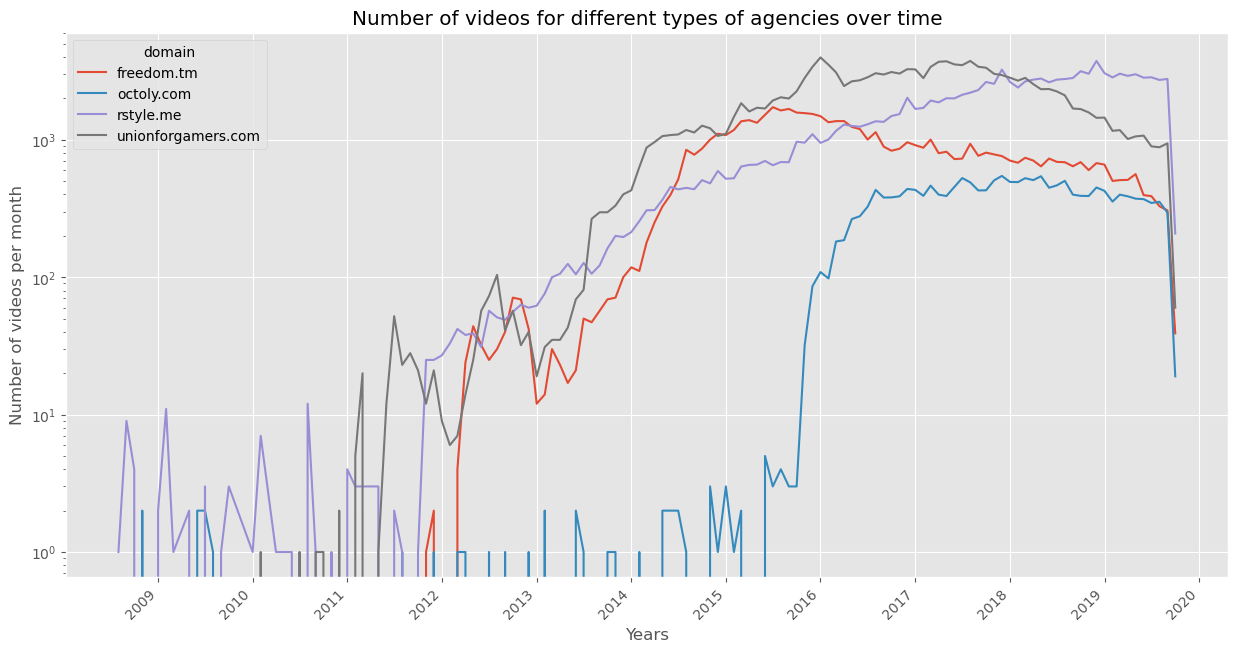

In [130]:
videos_agencies.plot.line(figsize=(15, 8))
plt.title("Number of videos for different types of agencies over time")
plt.xlabel("Years")
plt.ylabel("Number of videos per month")
plt.yscale("log")
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
plt.show()

We can see that the three sponsors appeared around the same time besides octoly.com, which appeared at the end of $2015$.

### Analysis of the categories of sponsoring domains over time

In [131]:
categories = (videos
        .filter(videos.is_sponsored)
        .pandas_api()
        .groupby(['month', "domain_category"])
        .size()
        .reset_index()
        .sort_index()
        .rename(columns={0: "count"})
        .astype({"month": "datetime64[ns]"})
).spark.persist()
categories.dtypes

month              datetime64[ns]
domain_category            object
count                       int64
dtype: object

In [132]:
categories = categories.pivot(index='month', columns='domain_category', values='count').sort_index().fillna(0)
categories.head(10)

domain_category,Agency,Application,Beauty,Book,Crypto,Education,Entertainment,Fashion,Finance,Food Drink,Media,Medical,Music,Photo,Real Estate,Religion,Service,Shop,Shorten,Social Media,Sport,Streaming,Technology,Travel,Vehicle,Video Game,YCW
month,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-12-01,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2006-03-01,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2006-04-01,5,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,3,0,0,0,0,0,0,0,0,0
2006-05-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0
2006-06-01,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
2006-07-01,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
2006-08-01,43,4,0,0,0,0,0,0,0,7,0,0,2,0,0,0,0,28,0,0,0,0,0,0,0,0,0
2006-09-01,67,9,0,0,0,0,0,0,0,0,0,3,8,0,0,0,0,27,0,0,0,0,0,0,0,0,0
2006-10-01,42,7,0,0,0,0,0,1,0,5,0,4,12,0,0,0,0,28,0,0,0,0,0,0,0,0,0


In [133]:
top_sponsored = categories.sum(axis=0).sort_values(ascending=False)
# We set the above Series' index order as the order of the columns of our dataframe
categories_top_sponsored = categories.reindex(columns=top_sponsored.index.to_list())
top_sponsored

C:\spark\spark-3.3.1-bin-hadoop3\python\pyspark\pandas\utils.py:975: PandasAPIOnSparkAdviceWarning: `to_list` loads all data into the driver's memory. It should only be used if the resulting list is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


domain_category
Application      2879138
Agency           2340121
Shop              956026
Video Game        665263
Technology        588092
Music             397657
Fashion           365171
Beauty            300179
Education         152406
Service           109526
Social Media       79017
Food Drink         78563
Crypto             58346
Book               54227
Travel             32801
Media              30168
Shorten            27600
Sport              26897
Streaming          22887
Vehicle            21940
Finance            21619
Entertainment      17115
Medical            14945
Photo              10175
Real Estate        10035
YCW                 5990
Religion            4798
dtype: int64

In [134]:
categories_top_sponsored.head()

domain_category,Application,Agency,Shop,Video Game,Technology,Music,Fashion,Beauty,Education,Service,Social Media,Food Drink,Crypto,Book,Travel,Media,Shorten,Sport,Streaming,Vehicle,Finance,Entertainment,Medical,Photo,Real Estate,YCW,Religion
month,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-12-01,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2006-03-01,6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2006-04-01,0,5,3,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2006-05-01,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2006-06-01,2,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [135]:
cmap = cm.get_cmap('tab20').copy()
cmap.set_over("whitesmoke")

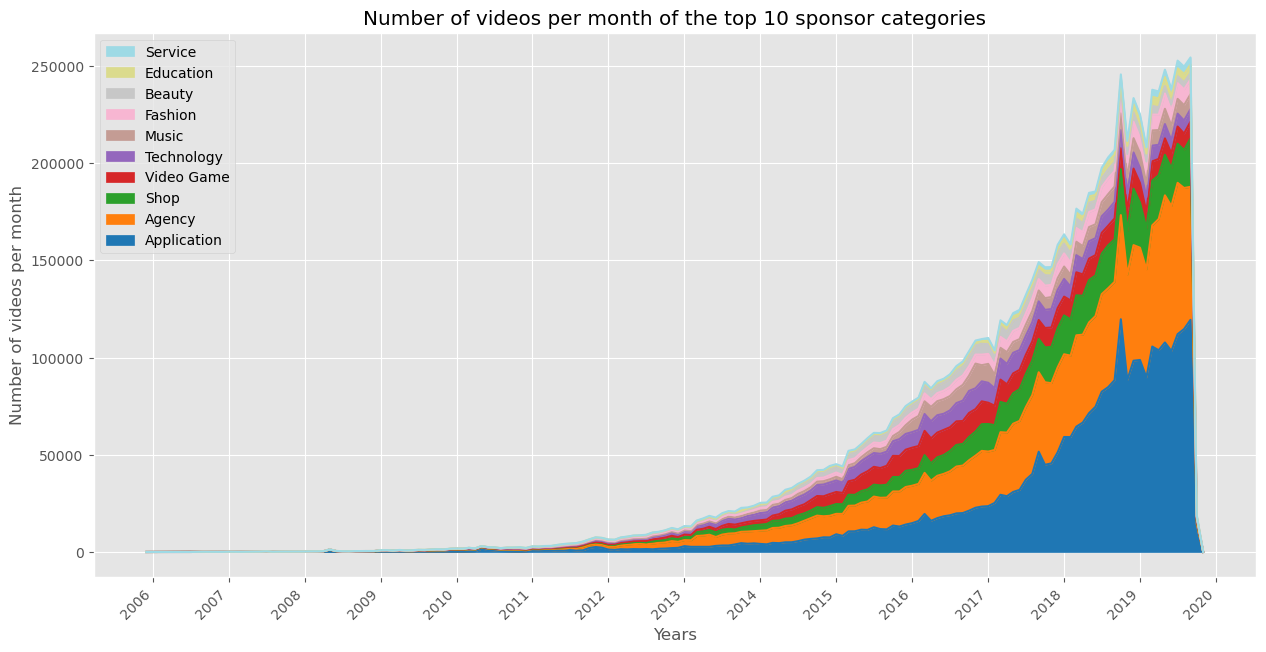

In [136]:
# Do a stacked plot instead of line plot to see the different categories
categories_top_sponsored.iloc[:,:10].spark.persist().plot.area(figsize=(15, 8), colormap=cmap)
plt.title("Number of videos per month of the top 10 sponsor categories")
plt.xlabel("Years")
plt.ylabel("Number of videos per month")
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])
plt.show()

Here is a stacked plot of the top 10 categories of sponsoring domains. We could see that the Application category has an immense increase after $2016$. We can also see a strange peak by the end of 2018. We will take a deeper look into this "anomaly" in a few cells below.

In [137]:
# Regroup all columns of categories_top_sponsor from the 11th to the last one into a single column called "others" by summing them
others = categories_top_sponsored.iloc[:,11:].sum(axis=1)
categories_top_sponsored_others: ps.DataFrame = categories_top_sponsored.iloc[:,:10].join(others, on="month").rename(columns={0: "Others"})
categories_top_sponsored_others.head()

,Application,Agency,Shop,Video Game,Technology,Music,Fashion,Beauty,Education,Service,Others
month,,,,,,,,,,,
2005-12-01,0,0,0,0,0,1,0,0,0,0,1
2006-03-01,6,0,1,0,0,0,0,0,0,0,0
2006-04-01,0,5,3,0,0,2,0,0,0,0,0
2006-05-01,0,0,3,0,0,0,0,0,0,0,0
2006-06-01,2,4,2,0,0,0,0,0,0,0,0


In [138]:
categories_ratios = categories_top_sponsored_others.apply(lambda x: x / x.sum(), axis=1).spark.persist()

C:\spark\spark-3.3.1-bin-hadoop3\python\pyspark\pandas\utils.py:975: PandasAPIOnSparkAdviceWarning: If the type hints is not specified for `apply`, it is expensive to infer the data type internally.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


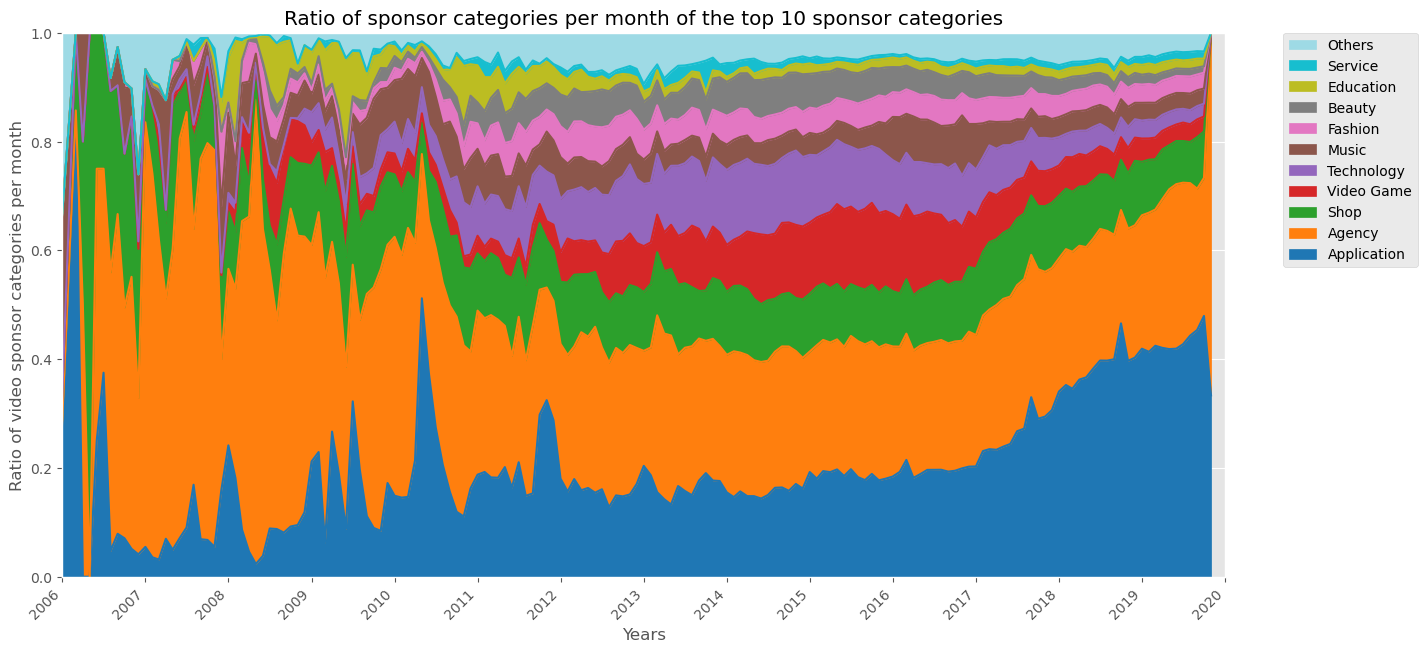

In [139]:
# Normalize each line by the total number of videos and plot the result
categories_ratios.plot.area(figsize=(15, 8), colormap=cmap)
plt.title("Ratio of sponsor categories per month of the top 10 sponsor categories")
plt.xlabel("Years")
plt.ylabel("Ratio of video sponsor categories per month")
plt.ylim(0, 1)
plt.xlim("2006-01-01", "2020-01-01")
# Put the legend outside of the plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# Revert the order of the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
plt.show()

Here is the same plot as before but represented rather with the share of each category rather than the exact count. We can see that the Agency category was the major one from the begining until about $2016$ where the Application category took over. \
One should take note that as the data before $2012$ is very limited, the share of each category is not very representative. Indeed, we can see that the shares vary a lot from one month to another.

C:\spark\spark-3.3.1-bin-hadoop3\python\pyspark\pandas\utils.py:975: PandasAPIOnSparkAdviceWarning: If the type hints is not specified for `apply`, it is expensive to infer the data type internally.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


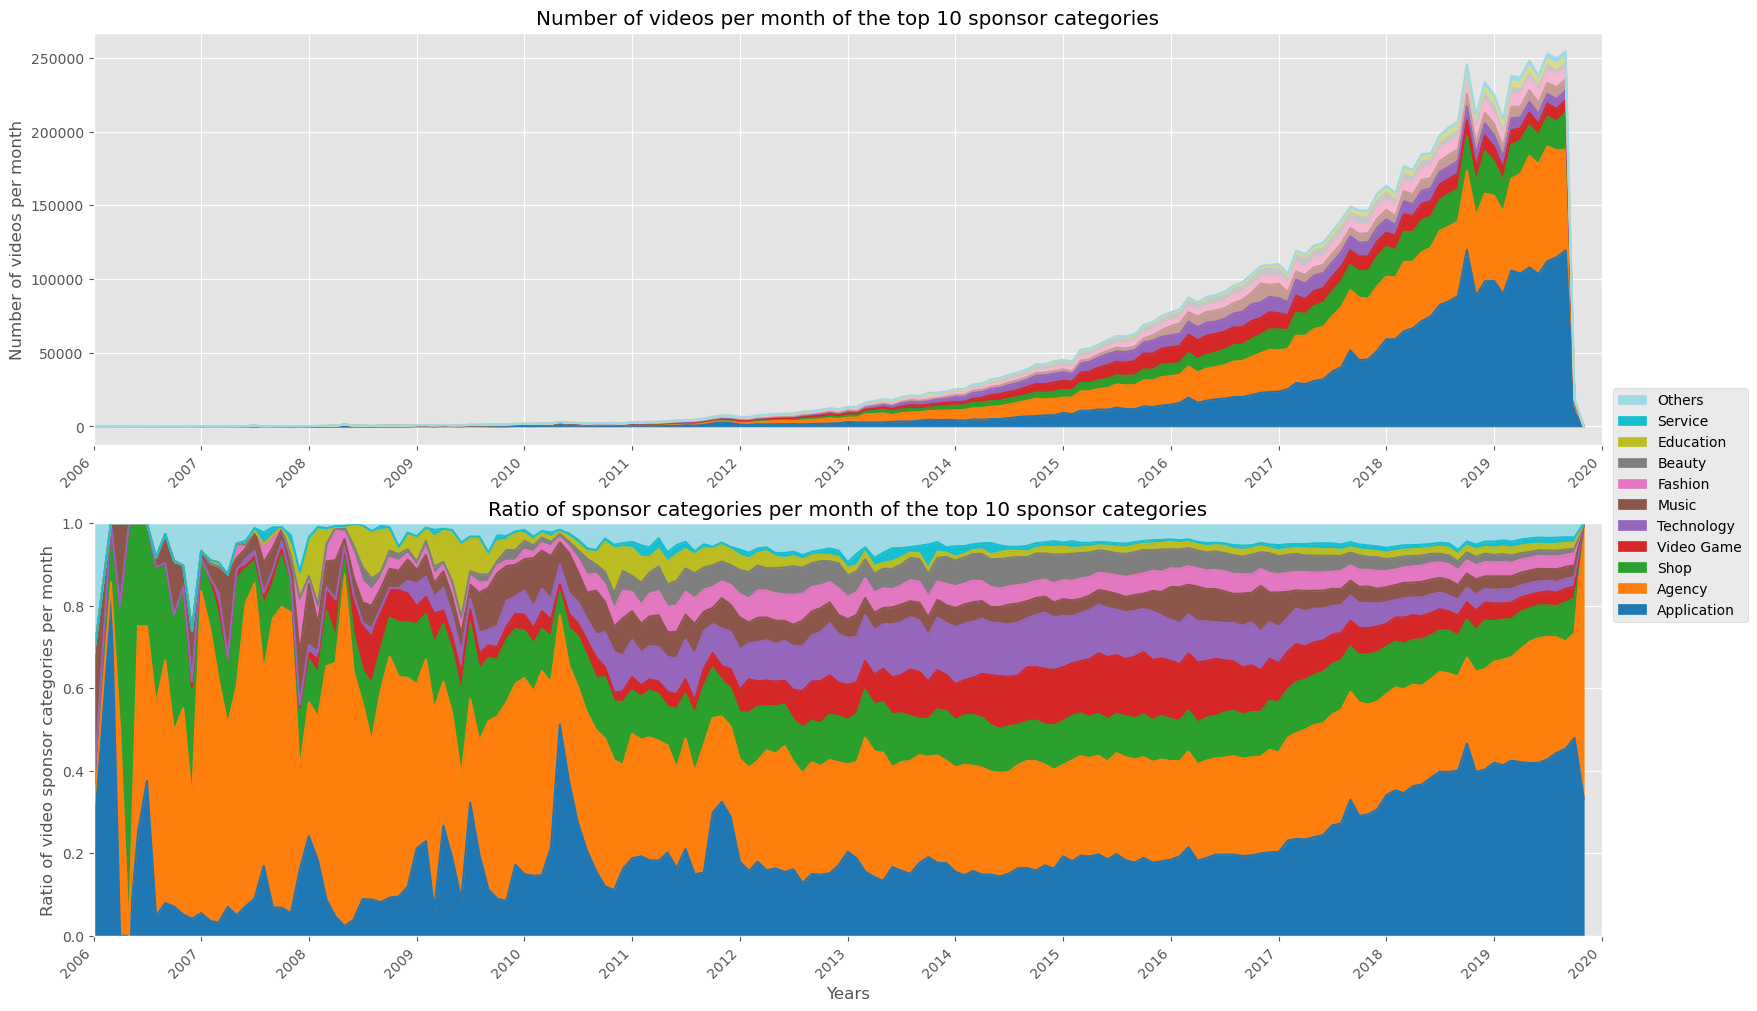

In [144]:
# Create a plot of 2 subplots of the plots above
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), layout="constrained")
#fig.tight_layout(h_pad=3.0)

# Plot the number of videos per month of the top 10 sponsor categories
# Do a stacked plot instead of line plot to see the different categories
categories_top_sponsored.iloc[:,:10].plot.area(ax=ax1, colormap=cmap)
ax1.set_title("Number of videos per month of the top 10 sponsor categories")
# remove the xlabel of the first plot
ax1.set_xlabel(None)
ax1.set_ylabel("Number of videos per month")
ax1.set_xlim("2006-01-01", "2020-01-01")
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.tick_params(axis='x', labelrotation=45)
ax1.get_legend().remove()

categories_top_sponsored_others.apply(lambda x: x / x.sum(), axis=1).plot.area(ax=ax2, colormap=cmap)
ax2.set_title("Ratio of sponsor categories per month of the top 10 sponsor categories")
ax2.set_xlabel("Years")
ax2.set_ylabel("Ratio of video sponsor categories per month")
ax2.set_ylim(0, 1)
ax2.set_xlim("2006-01-01", "2020-01-01")
# Put the legend outside of the plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# Revert the order of the legend
handles, labels = ax2.get_legend_handles_labels()
#ax2.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.tick_params(axis='x', labelrotation=45)
ax2.get_legend().remove()

# Put legend outside of the plot to the right
fig.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("../images/sponsor_categories.svg", format="svg", bbox_inches="tight")
plt.show()

Here is the two plots combined into one so to make it easier to compare both. As said above, due to the lack of data, the share distributions before $2012$ is very volatile and hence not representative.

In [ ]:
categories_days = (videos
        .filter(videos.is_sponsored)
        .pandas_api()
        .groupby(['upload_date', "domain_category"])
        .size()
        .reset_index()
        .sort_index()
        .rename(columns={0: "count"})
)
categories_days = categories_days.pivot(index='upload_date', columns='domain_category', values='count').sort_index().fillna(0)
top_sponsored = categories_days.sum(axis=0).sort_values(ascending=False)
# We set the above Series' index order as the order of the columns of our dataframe
categories_top_sponsored_days = categories_days.reindex(columns=top_sponsored.index.to_list())

C:\spark\spark-3.3.1-bin-hadoop3\python\pyspark\pandas\utils.py:975: PandasAPIOnSparkAdviceWarning: `to_list` loads all data into the driver's memory. It should only be used if the resulting list is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [ ]:
to_plot_cat = categories_top_sponsored_days.reset_index().to_pandas()
to_plot_cat.head()

C:\spark\spark-3.3.1-bin-hadoop3\python\pyspark\pandas\utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


domain_category,upload_date,Application,Agency,Shop,Video Game,Technology,Music,Fashion,Beauty,Education,...,Sport,Streaming,Vehicle,Finance,Entertainment,Medical,Photo,Real Estate,YCW,Religion
0,2005-12-28,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,2005-12-29,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2006-03-08,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2006-03-13,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006-03-14,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
top_to_plot = to_plot_cat.iloc[:, :11]

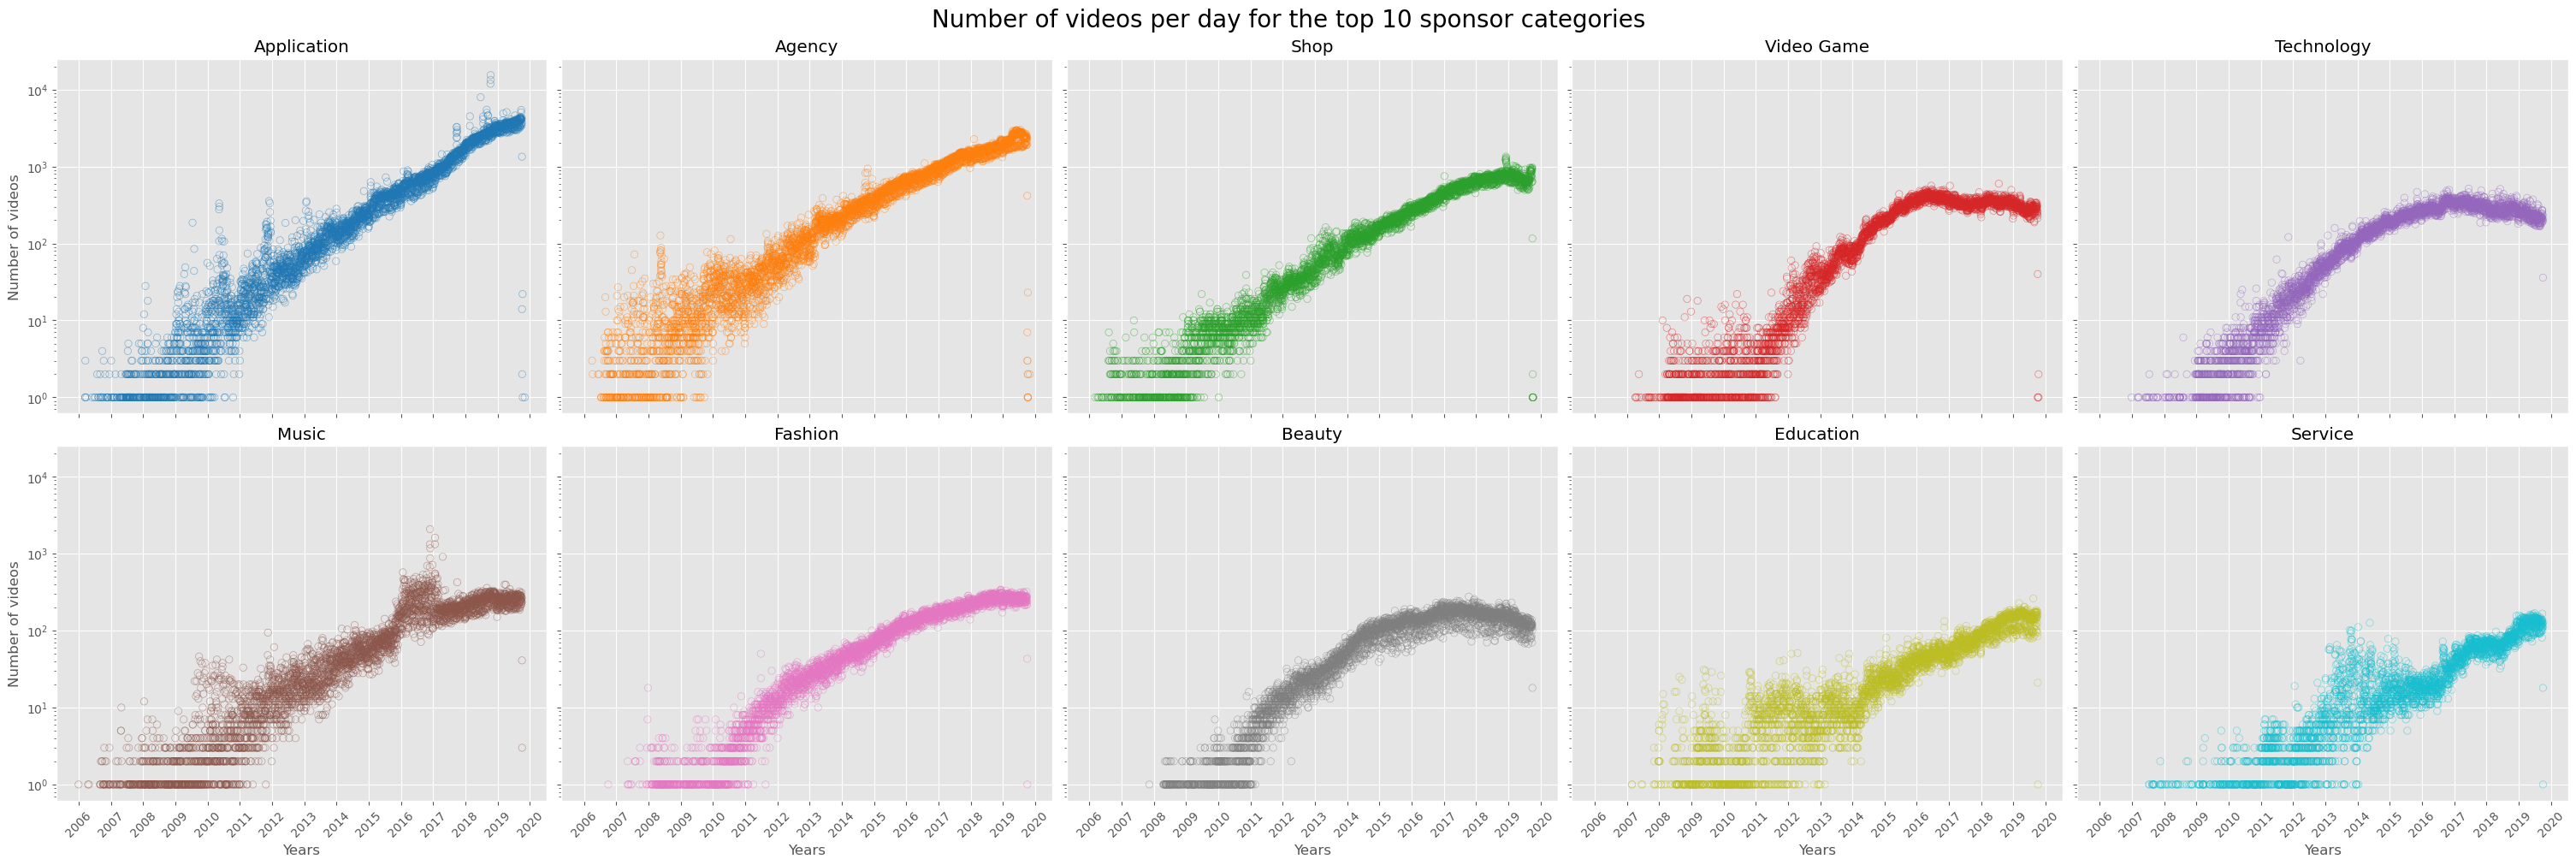

In [178]:
# plot a scatter plot for each category in top_to_plot in a 2 x 5 figure
cmap2 = cm.get_cmap('tab10').copy()
fig, axes = plt.subplots(2, 5, figsize=(30, 10), layout="constrained", sharex=True, sharey=True)
fig.suptitle("Number of videos per day for the top 10 sponsor categories", fontsize=20)
for i, (category, ax, color) in enumerate(zip(top_to_plot.columns[1:], axes.flatten(), cmap2.colors)):
    ax.scatter(x=top_to_plot["upload_date"], y=top_to_plot[category], alpha=0.5, facecolors='none', edgecolors=color)
    #top_to_plot.plot.scatter(x="upload_date", y=category, ax=ax)
    ax.set_title(category)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_yscale("log")
    if i > 4:
        ax.set_xlabel("Years")
    if i % 5 == 0:
        ax.set_ylabel("Number of videos")
    #raise Exception("stop")
plt.savefig("../images/sponsor_categories_scatter.svg", format="svg", bbox_inches="tight")
plt.show()

In these plots, we can see the evolution of the number of videos published everyday for each of the top 10 categories. We can see that the application and agency grow in an exponential manner since the beggining are do not seem to slow down compared to the other categories, which after a certain point start to decay. \
Strangely enough, there is an increase in the number of videos publised everyday with the Music category during the whole year of $2016$. This corresponds to the lauch of YouTube Music on the $12\text{th of November }2015$.

#### Music boost ?

We will now take a deeper look into the Music category. We will see if the increase in the number of videos published everyday is due to the launch of YouTube Music or if it is due to something else.

In [11]:
music_videos = (videos
        .filter((videos.is_sponsored) & (videos.domain_category == "Music") & (videos.upload_date < "2017-12-31")  & (videos.upload_date > "2015-01-01"))
        .pandas_api()
        .astype({"month": "datetime64[ns]", "upload_date": "datetime64[ns]"})
)
music_videos["year"] = music_videos["upload_date"].dt.year
music_videos.dtypes

domain                     object
display_id                 object
channel_id                 object
title                      object
upload_date        datetime64[ns]
duration                    int32
view_count                  int64
like_count                  int32
dislike_count               int32
tags                       object
is_sponsored                 bool
domain_category            object
month              datetime64[ns]
year                        int64
dtype: object

In [13]:
music_videos.groupby(["year", "channel_id"]).size().sort_values(ascending=False).head(20)

year  channel_id              
2016  UCtQVQp-4weglkE1svqJuddg    39786
      UCavOAbLX45b2hVkF4i82sZw    11538
2017  UCtQVQp-4weglkE1svqJuddg     8523
2015  UC27SlGGzeAi_mRqiQ6Hzg4Q     4150
      UCmFp3gyBXLirYZRCfDh6PjQ     3868
2016  UCmFp3gyBXLirYZRCfDh6PjQ     3364
      UC27SlGGzeAi_mRqiQ6Hzg4Q     2472
2017  UCmFp3gyBXLirYZRCfDh6PjQ     2229
2015  UCavOAbLX45b2hVkF4i82sZw     1565
2017  UCi14bJWs6zQFmDtkCel8nIw     1437
2016  UCNApqoVYJbYSrni4YsbXzyQ     1242
2015  UCNApqoVYJbYSrni4YsbXzyQ     1129
2016  UCi14bJWs6zQFmDtkCel8nIw      987
      UCG8cQBZrG2-Q76hlAZ-Et9g      946
2017  UCe0j_gCr3Fwx2QQ-Qlhvw3g      943
      UCv-C6s7WAZLVnRQHbutSDJg      934
      UCAKvz1S59GSW4e4-b--K6Ug      843
2015  UCi14bJWs6zQFmDtkCel8nIw      803
2016  UCwfYU2M8TBAus0TIaNtjxlQ      778
2017  UCHAZGk9aw1RY64QU_Wol0IQ      770
dtype: int64

In [14]:
music_videos.groupby(["month", "channel_id"]).size().sort_values(ascending=False).head(20)

month       channel_id              
2016-11-01  UCtQVQp-4weglkE1svqJuddg    8356
2017-01-01  UCtQVQp-4weglkE1svqJuddg    5122
2016-12-01  UCtQVQp-4weglkE1svqJuddg    4156
2016-09-01  UCtQVQp-4weglkE1svqJuddg    3450
2016-07-01  UCtQVQp-4weglkE1svqJuddg    3111
2016-10-01  UCtQVQp-4weglkE1svqJuddg    3090
2016-02-01  UCtQVQp-4weglkE1svqJuddg    2913
2016-08-01  UCtQVQp-4weglkE1svqJuddg    2859
2016-06-01  UCtQVQp-4weglkE1svqJuddg    2858
2016-05-01  UCtQVQp-4weglkE1svqJuddg    2580
2016-04-01  UCtQVQp-4weglkE1svqJuddg    2575
2016-03-01  UCtQVQp-4weglkE1svqJuddg    2454
2017-02-01  UCtQVQp-4weglkE1svqJuddg    2331
2016-01-01  UCavOAbLX45b2hVkF4i82sZw    1601
2016-04-01  UCavOAbLX45b2hVkF4i82sZw    1550
2016-01-01  UCtQVQp-4weglkE1svqJuddg    1384
2015-12-01  UCavOAbLX45b2hVkF4i82sZw    1230
2016-02-01  UCavOAbLX45b2hVkF4i82sZw    1200
2016-03-01  UCavOAbLX45b2hVkF4i82sZw    1142
2016-07-01  UCavOAbLX45b2hVkF4i82sZw    1103
dtype: int64

We can see that the channel with `channel_id` UCtQVQp-4weglkE1svqJuddg published $39786$ videos mentioning a Music domain. This is about $109$ videos published everyday. However, unfortunately, this channel does not exist anymore. We can however find its traces using [wayback machine](https://web.archive.org/web/20190406001731/https://www.youtube.com/channel/UCtQVQp-4weglkE1svqJuddg). It is the channel of [Feiyr](https://www.feiyr.com/en/main.html), which "helps music producers promote and market their music". They also sponsor YouTubers as it can be seen from their [own link](https://www.feiyr.com/EarnMoneyWithYoutube). It is interessting to note that Feiyr publised $39786$ videos in $2016$, which is $4.6$ times more than the maximum number of videos mentioning a music domain published by a channel for 2017 (which were themselves again) and $9.7$ times more than the maximum for $2015$ (a different channel this time). \
We can aslo see that they are the channel that publishes the most videos per month from $\text{Febuary }2016$ to $\text{Febuary }2017$. We could hence conclude that this increase might not be due to the launch of YouTube Music but rather to the abnormal activity of this channel.

#### A strange peak ?

Now we will take a closer look at the peak that appeares in the Application category at the end of $2018$.

In [78]:
# Compute the percentage difference of the number of videos throughout October 2018
categories_top_sponsored["Application"].loc["2018-01-01":"2018-12-31"].to_frame("count").join(
    categories_top_sponsored["Application"].loc["2018-01-01":"2018-12-31"].pct_change().to_frame("pct_change")
)

,count,pct_change
month,,
2018-01-01,59156,NaN
2018-02-01,59106,-0.000845
2018-03-01,64465,0.090668
2018-04-01,66586,0.032902
2018-05-01,71420,0.072598
2018-06-01,74705,0.045996
2018-07-01,82441,0.103554
2018-08-01,84779,0.028360
2018-09-01,88410,0.042829


We can see that during the month of October 2018, the Application category got increased by $35.4\%$ ! This is surprising as, throughout the year, the number of videos mentioning an Application sponsor was rather stable.

In [41]:
october_2018_apps = videos \
    .filter((videos["is_sponsored"]) & (videos["domain_category"] == "Application") & (videos["month"] == "2018-10-01")) \
    .persist() \
    .pandas_api() \
    .astype({"month": "datetime64[ns]", "upload_date": "datetime64[ns]"})
october_2018_apps.dtypes

domain                     object
display_id                 object
channel_id                 object
title                      object
upload_date        datetime64[ns]
duration                    int32
view_count                  int64
like_count                  int32
dislike_count               int32
tags                       object
is_sponsored                 bool
domain_category            object
month              datetime64[ns]
dtype: object

In [63]:
october_2018_apps_cnt = october_2018_apps.groupby("upload_date").size().sort_index()
# rename the column to "count"
october_2018_apps_cnt.to_frame("count").join(october_2018_apps_cnt.pct_change().to_frame("pct_change"))

,count,pct_change
upload_date,,
2018-10-01,3079,NaN
2018-10-02,2762,-0.102956
2018-10-03,3127,0.132151
2018-10-04,3062,-0.020787
2018-10-05,3235,0.056499
2018-10-06,2723,-0.158269
2018-10-07,2720,-0.001102
2018-10-08,2862,0.052206
2018-10-09,2989,0.044375


We can see that on the $11\text{th of October }2018$, $12\text{th of October }2018$ and $13\text{th of October }2018$, the number of videos mentioning an Application sponsor went from about 3000 videos a day to 12, 13 and 15 thousand vidoes on these days. It is a change of $270\%$ form the $10\text{th}$ to the $11\text{th}$!!!!!

In [75]:
# We try to find whether a single channel is responsible for the increase in the number of videos
top_channels_october = \
    october_2018_apps[("2018-10-11" <= october_2018_apps.upload_date) & (october_2018_apps.upload_date < "2018-10-14")] \
    .groupby("channel_id") \
    .size() \
    .sort_values(ascending=False)
top_channels_october.to_frame("count").join(top_channels_october.div(top_channels_october.sum()).to_frame("share")).head(10)

,count,share
channel_id,,
UCcv7pspGHmM7AOywuLM1ufA,31259,0.770647
UCPXTXMecYqnRKNdqdVOGSFg,400,0.009861
UCEwBXEpzJanR-ntextgHMgw,282,0.006952
UCDCMjD1XIAsCZsYHNMGVcog,258,0.006361
UC_2irx_BQR7RsBKmUV9fePQ,222,0.005473
UCLcdLec-U0jy2oFhX-MYlsw,190,0.004684
UC1vOCYEu3DfoI4fYcfWKmWA,156,0.003846
UCbf8Mqg0EF-7p2JKJ3fhH8A,140,0.003452
UC8dnBi4WUErqYQHZ4PfsLTg,128,0.003156


In [76]:
october_2018_apps[("2018-10-11" <= october_2018_apps.upload_date) & (october_2018_apps.upload_date < "2018-10-14")].head(10)

,domain,display_id,channel_id,title,upload_date,duration,view_count,like_count,dislike_count,tags,is_sponsored,domain_category,month
0,play.google.com,-NMXGTpaHcc,UCcv7pspGHmM7AOywuLM1ufA,The area of the quadrilateral with its vertice...,2018-10-11,560,50,0,0,,True,Application,2018-10-01
1,streamlabs.com,-RXsO76npj0,UCPfoJ4hyGifp4pcCppHeZfA,Drake Finally Expose Kanye West On HBO Show,2018-10-12,2745,16292,224,56,"Djvlad,bossip,complex,vh1,dj akademiks,tmz,bet...",True,Application,2018-10-01
6,play.google.com,08pkleGtsZM,UCI_mwTKUhicNzFrhm33MzBQ,"""15%-20% rise in direct tax collections every ...",2018-10-12,84,186,1,0,"arun jaitley,arun jaitley latest,fm arun jaitl...",True,Application,2018-10-01
7,apps.apple.com,08pkleGtsZM,UCI_mwTKUhicNzFrhm33MzBQ,"""15%-20% rise in direct tax collections every ...",2018-10-12,84,186,1,0,"arun jaitley,arun jaitley latest,fm arun jaitl...",True,Application,2018-10-01
10,play.google.com,0KDjnstTWWI,UCcv7pspGHmM7AOywuLM1ufA,`(dy)/(dx)=(e^y)/(x^2)-1/x`,2018-10-12,270,1,0,0,,True,Application,2018-10-01
14,play.google.com,0flx8XPsNog,UCcv7pspGHmM7AOywuLM1ufA,A parallelogram is inscribed in the ellipse `x...,2018-10-12,221,124,1,0,,True,Application,2018-10-01
16,play.google.com,14szLBX-WBk,UCcv7pspGHmM7AOywuLM1ufA,If ` sin2A= lambda sin 2B` prove that `(tan(A+...,2018-10-12,152,447,5,2,,True,Application,2018-10-01
21,play.google.com,1dSACyrLePQ,UCcv7pspGHmM7AOywuLM1ufA,The average of 5 numbers is 43. What is the co...,2018-10-13,103,8,0,0,,True,Application,2018-10-01
27,play.google.com,1y6VGx7OK_c,UCcv7pspGHmM7AOywuLM1ufA,"If `x,y,z` are three consecutive positive inte...",2018-10-13,323,3,0,0,,True,Application,2018-10-01
30,play.google.com,2DiJw4ChV90,UCcv7pspGHmM7AOywuLM1ufA,find domain of `y=cos^(-1)((2x+1)/(2sqrt(2x)))`,2018-10-12,217,10,0,0,,True,Application,2018-10-01


We can see that the channel with `channel_id` UCcv7pspGHmM7AOywuLM1ufA has posted $77\%$ of the total videos containing an Application domain during this three day period (this represents about $32000$ videos in just $3$ days!!). The channel is Doubtnut [https://www.youtube.com/channel/UCcv7pspGHmM7AOywuLM1ufA/](https://www.youtube.com/channel/UCcv7pspGHmM7AOywuLM1ufA/), an Indian tutoring platform and app for physics, mathematical and chemistry questions that also has a YouTube channel that was launched on the $1\text{st of July }2016$. Besides this finding, we were not able to determine the reason for this sudden increase in the number of videos published during these $3$ days. Some hypothesis might be that the channel decided to archive all their videos during these two days, maybe the channel was hacked and hence they had to republish all old videos.